In [1]:
from helper import (load_data, token, DanishCleaner,time_me,
                    show_diagram, show_most_informative_features)

In [2]:
## Long process timing that %time does not work
from datetime import datetime
import humanfriendly


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight') # plt.style.available

In [4]:
from sklearn.externals import joblib
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)

#### TfidfVectorizer == CountVectorizer + TfidfTransformer

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression

In [6]:
stops = joblib.load('../stops.pkl')

Loading data ...
Droping 10 rows with features lenght of less than 2
Droping 3 as rating and setting 1-2 as negative(0), 4-5 as positive(1))
{1: 460527, 0: 127232} 

Down sampling positive ratings to match negatives
Data loading completed
{1: 127232, 0: 127232} 

Execution Time: 4 seconds


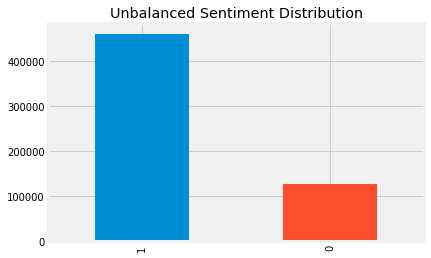

In [7]:
df = load_data('../sentiment_data', balanced=True)

In [8]:
 X_train, X_test, y_train, y_test = train_test_split(df['features'], df['y'],
                                                    test_size=.2, random_state=7,stratify=df['y'])

In [9]:
print(f'Traing Size: {X_train.shape[0]}\nTest Size: {X_test.shape[0]:>8}')

Traing Size: 203571
Test Size:    50893


In [10]:
print(f'Traing Size\n\tPositive||Negative Sample\n\t  {y_train[y_train==1].shape[0]}||{y_train[y_train==0].shape[0]}')

Traing Size
	Positive||Negative Sample
	  101785||101786


In [11]:
print(f'Test Size\n\tPositive||Negative Sample\n\t  {y_test[y_test==1].shape[0]}||{y_test[y_test==0].shape[0]}')

Test Size
	Positive||Negative Sample
	  25447||25446


In [12]:
count_para = dict(ngram_range=(2, 3),tokenizer=token,
                     lowercase=True,stop_words=stops,min_df=10)
tfidf_para = dict(ngram_range=(2, 3), lowercase=True,max_df=.8,
                  min_df=10, sublinear_tf=True,stop_words=stops)

lda_para = dict(n_components=2, max_iter=100, learning_method='online', verbose=1,
                learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,random_state=7)

logit_para = dict(C=1., penalty='l2',max_iter=500,random_state=7,warm_start=True, 
                  verbose=1, solver='saga', n_jobs=4)  #n_jobs=-1 does not have any effect when solver is liblinear l2



In [13]:
model = Pipeline ([
    ('text_union', FeatureUnion([
                        ('lda_pipe', Pipeline([
                            ('countvec', CountVectorizer(**count_para)),
                            ('fe_se', SelectKBest(chi2, k=5000)),
                            ('lda',LatentDirichletAllocation(**lda_para))
                                            ])),
                        ('tfidf_pipe', Pipeline([
                                            ('tfidf', TfidfVectorizer(**tfidf_para)),
                                            ('fe_se', SelectKBest(chi2, k=5000))
                                                            ])),
                                        
                                                ])
                    ),
    ('clf', LogisticRegression(**logit_para))
    
])

In [14]:
print('Model training ...')
u = datetime.now()
model.fit(X_train, y_train)
v = datetime.now()

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.2s finished


In [15]:
delta = v-u
print('Training took: {}'.format(
            humanfriendly.format_timespan(delta.seconds)))

Training took: 1 hour and 43 seconds


Classification Report
	 _____________________________________________
             precision    recall  f1-score   support

   Negative       0.93      0.82      0.87     25446
   Positive       0.84      0.94      0.89     25447

avg / total       0.88      0.88      0.88     50893

	 _____________________________________________ 




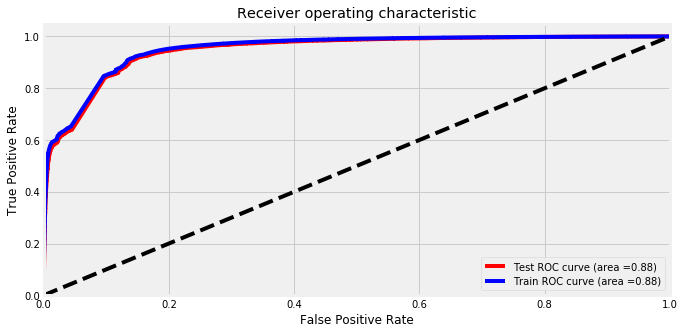

Execution Time: 4 minutes and 53 seconds


In [16]:
show_diagram(model,X_train, y_train, X_test, y_test,compare_test=True)

In [17]:
vec_features = model.steps[0][1].transformer_list[0][1].steps[0][1].get_feature_names()
best_vec_features = [vec_features[i] for i in  model.steps[0][1].transformer_list[0][1].steps[1][1].get_support(indices=True)]

In [18]:
tf_features  = model.steps[0][1].transformer_list[1][1].steps[0][1].get_feature_names()
best_tf_features = [tf_features[i] for i in  model.steps[0][1].transformer_list[1][1].steps[1][1].get_support(indices=True)] # step 1 == fe_se

In [19]:
show_most_informative_features(best_vec_features, model.steps[1][1], n=50)

	-8.3296	kanal ikk      		6.8966	løsning problem
	-7.6495	skul ha        		5.9313	pak hel ikk    
	-7.4122	kontak kund    		5.9291	stil vid       
	-6.7503	ikk råd        		5.5998	igen betal     
	-6.3711	eft først      		5.5084	ikk formår     
	-6.3341	hjem hel tid   		5.4009	sted ikk       
	-6.2641	ikk styr nog   		5.1093	return afsend  
	-6.2529	ikk net        		4.8060	haft tdc       
	-6.2028	and mul        		4.8057	hav brugt      
	-6.0607	skift udbyd    		4.7592	sted skul      
	-5.7364	medarbejd eft  		4.7008	havd lig       
	-5.7037	vær løgn       		4.5818	hav modtag pak 
	-5.6711	ikk servic     		4.5756	fung rigt      
	-5.6691	mega dår servic		4.5756	medarbejd havd 
	-5.6601	nem hurt       		4.5485	vid modtag     
	-5.6550	forstå pak     		4.4584	styr nog       
	-5.6014	eft eft        		4.4355	håb ikk        
	-5.5584	ing havd       		4.4042	igen sen       
	-5.4918	øvr ikk        		4.3965	bar skriv      
	-5.4601	eft hav stået  		4.3605	engang forsøg  
	-5.4461	ikk tilbud 

In [20]:
show_most_informative_features(best_tf_features, model.steps[1][1], n=50)

	-8.3296	ikke modtaget ikke		6.8966	ingen problemer gik
	-7.6495	stadig ikke finde		5.9313	nemt hurtigt effektivt
	-7.4122	ikke ordentligt		5.9291	super hurtig døren
	-6.7503	ikke engang finde		5.5998	hurtig god betjening
	-6.3711	dårlig rådgivning		5.5084	hurtigt nemt effektivt
	-6.3341	heller ikke fået		5.4009	super god betjening
	-6.2641	ikke fået ikke 		5.1093	rigtig god betjening
	-6.2529	ikke anbefale telenor		4.8060	god hurtig betjening
	-6.2028	al lang        		4.8057	god information hurtig
	-6.0607	slet ikke forsøgt		4.7592	super godt hurtig
	-5.7364	intet klage    		4.7008	godt tilfredse 
	-5.7037	virkelig dårlig oplevelse		4.5818	god oplevelse handle
	-5.6711	ikke finde aflevere		4.5756	fundet ikke    
	-5.6691	kommet endnu   		4.5756	intet negativt 
	-5.6601	lave fejl      		4.5485	vedkommende ikke
	-5.6550	forsøgt aflevere adressen		4.4584	super nemt hurtig
	-5.6014	dårlig kvalitet		4.4355	hurtig effektiv betjening
	-5.5584	ikke kommet frem		4.4042	hurtig nem betjening
	-5